# 13. 生成分野

このChapterでは敵対的生成ネットワーク(Generative Adversarial Networks。 以下、GAN)と畳み込みニューラルネットを用いたGANであるDCGAN(Deep Convolutional GAN)を用いて画像生成を行います。

所要時間：<font color="Red">5~8時間</font>

### 【Google colabのみ実行】ライブラリのインストール

必要なライブラリのインストールと、実行環境のバージョンを統一します。<br>

使用するライブラリ名とバージョンは配布資料の<font color=Red>「requirements.txt」</font>で確認できます。

※以下のセルを実行しましたら、「ランタイム」→「ランタイムを再起動」により<font color=Red>再起動</font>を行ってください。

In [ ]:
import sys
# Google colab環境であるか判定
if 'google.colab' in sys.modules:
    # ライブラリのインストール
    !pip install torch==1.13.0 torchvision==0.14.0
else:
    print("Not Google Colab")

### ライブラリのインポート

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torch.autograd as autograd
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from tqdm import tqdm
%matplotlib inline
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## GANを用いた画像生成（PyTorch）

まずはGANを用いたMNIST画像の生成を行います。

MNISTは0~9の手書き数字が画像になった画像データと書かれた数字の正解ラベルで構成されているデータセットです。。データセット全体は70000件で構成されています。

GANは生成器(Generator)が訓練データそっくりの（偽物の）データを生成し、その生成データが偽物か本物か識別器(Discriminiator)が識別することで学習する手法です。

生成器と識別器が敵対している様子から敵対的生成ネットワークと呼ばれています。

GANは以下の手順で学習します。

1. 一様乱数からノイズ`z`をサンプリング

2. Generatorによって偽のデータを生成

3. 混ぜられた観測データ（真）と生成データ（偽）を、Discriminatorが識別

4. Generatorは損失関数が小さくなるように、Discriminatorは損失関数が大きくなるように学習

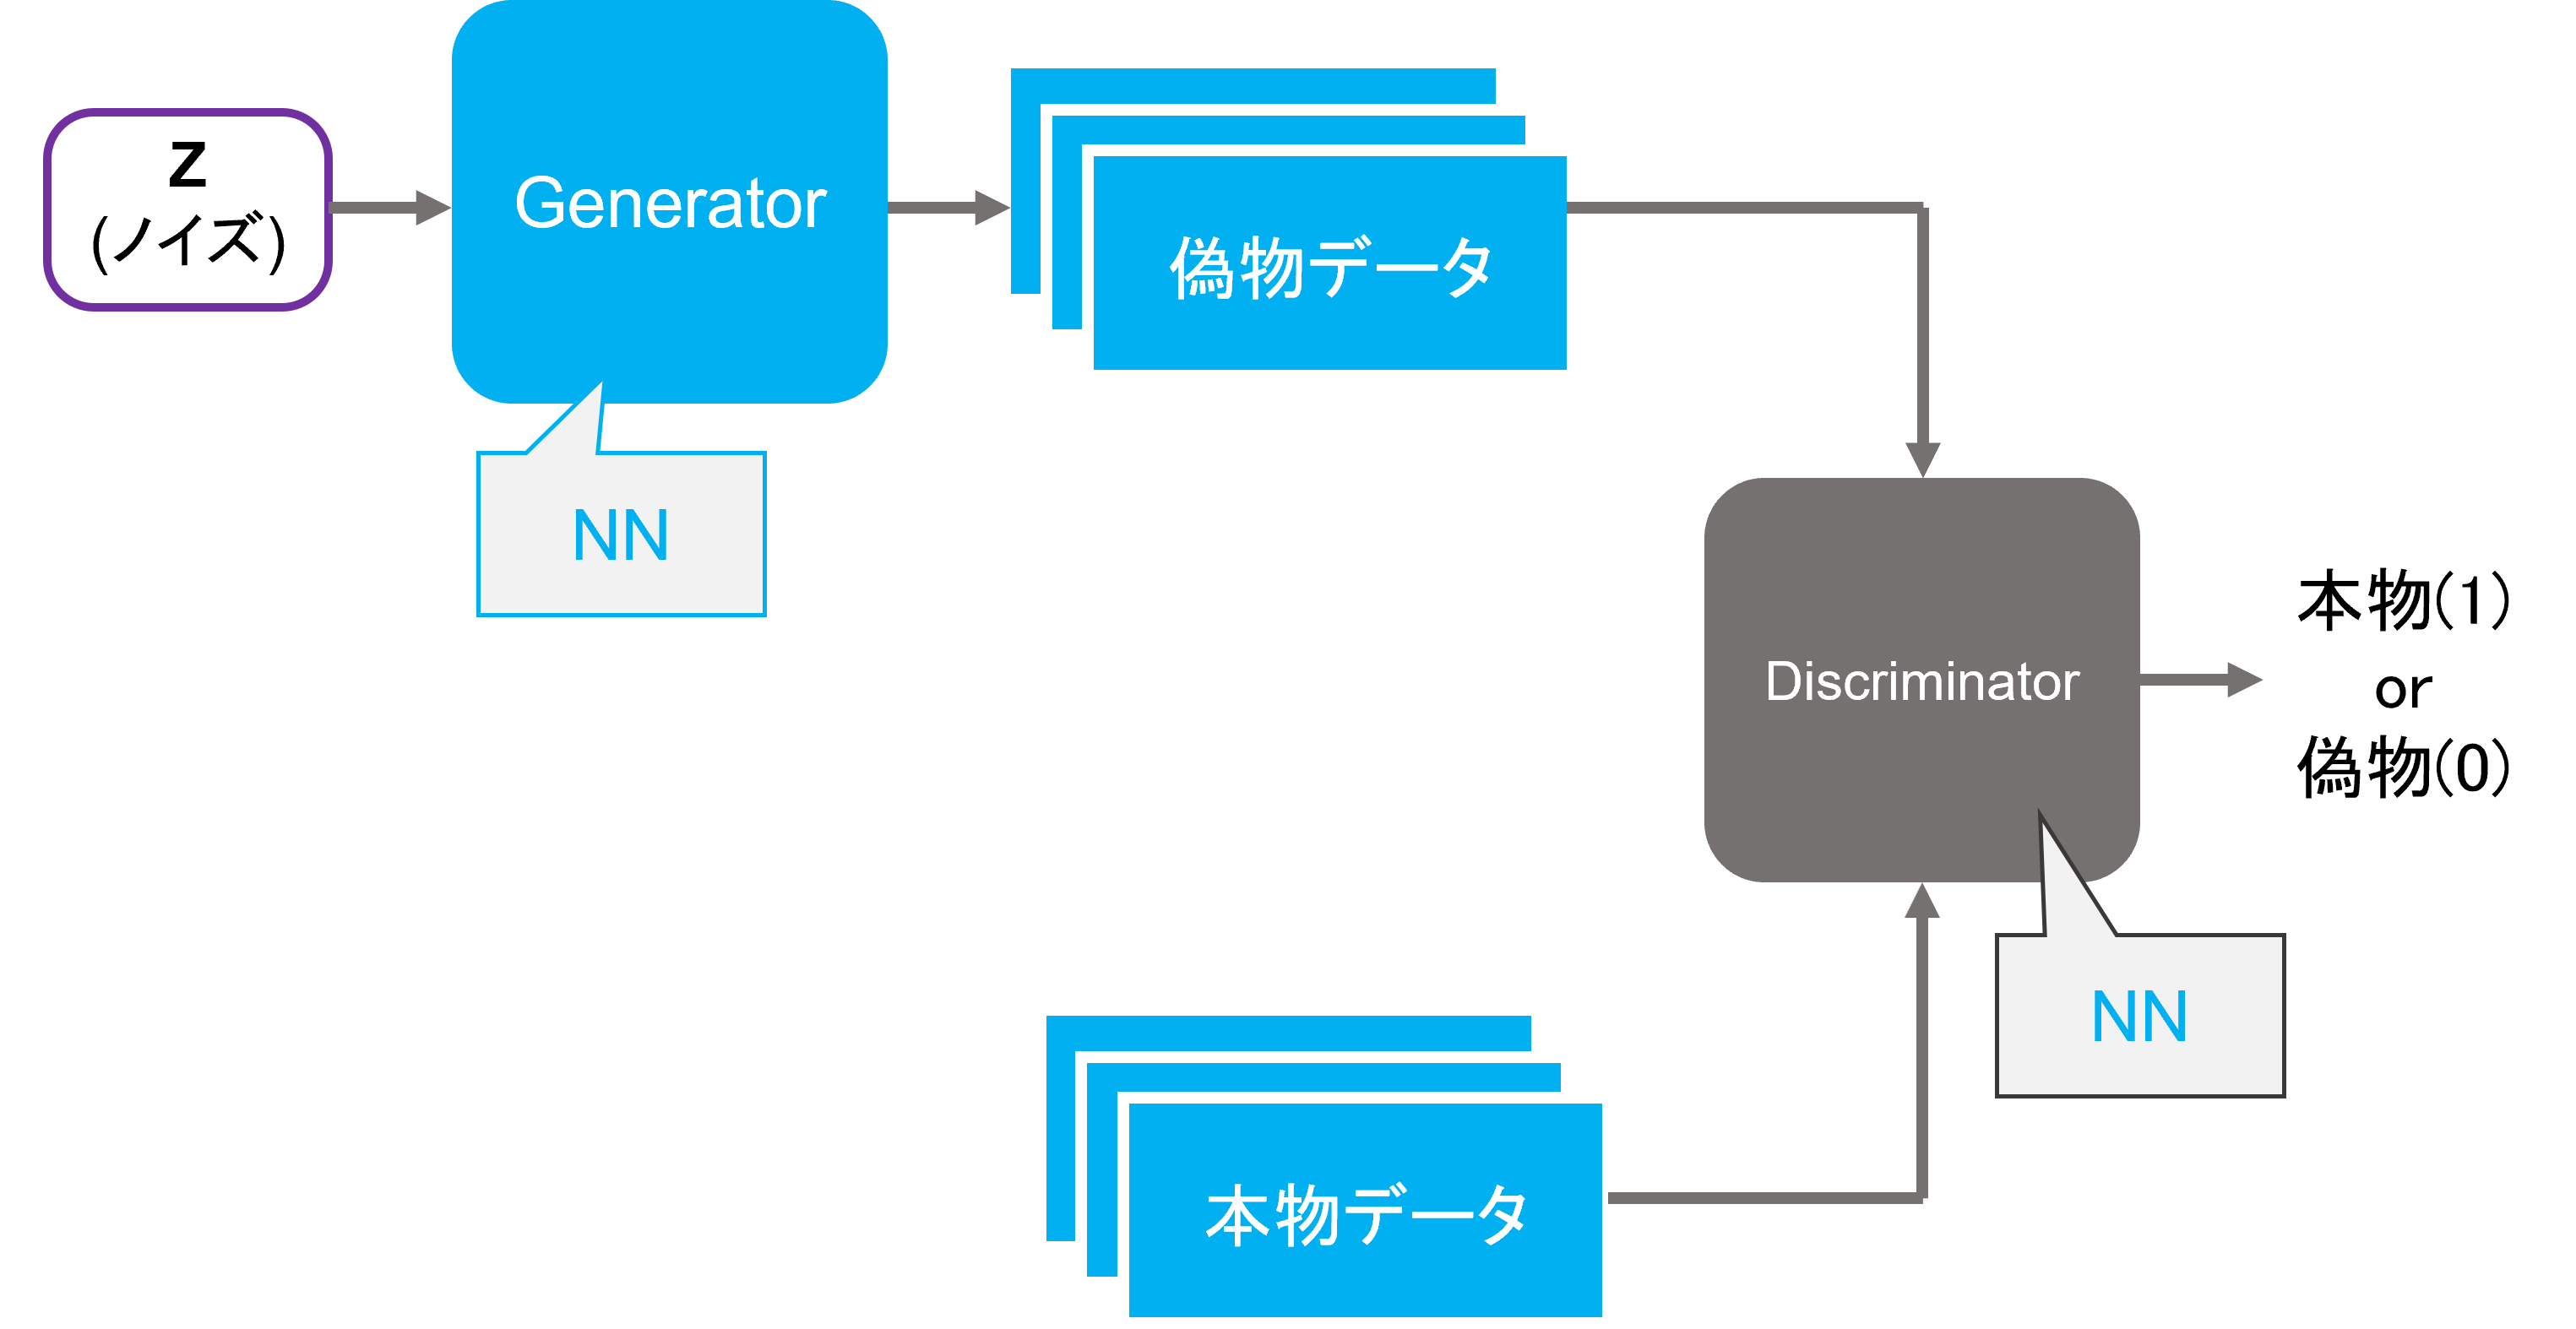

### データセットの用意

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor()
])

batch_size = 64

dataloader_train = torch.utils.data.DataLoader(
    datasets.MNIST(root='./data', train=True, download=True, transform=transform),
    batch_size=batch_size,
    shuffle=False
)

In [ ]:
# データの確認
batch_train = next(iter(dataloader_train))
print(batch_train[0].shape)

# データを5つ表示
for i in range(5):
    plt.gray()
    plt.imshow(batch_train[0][i].squeeze(0))
    plt.show()
    print("label: ", batch_train[1][i])

### 生成器

生成器を実装します。

今回は次の構造を持つ生成器を構築しましょう。

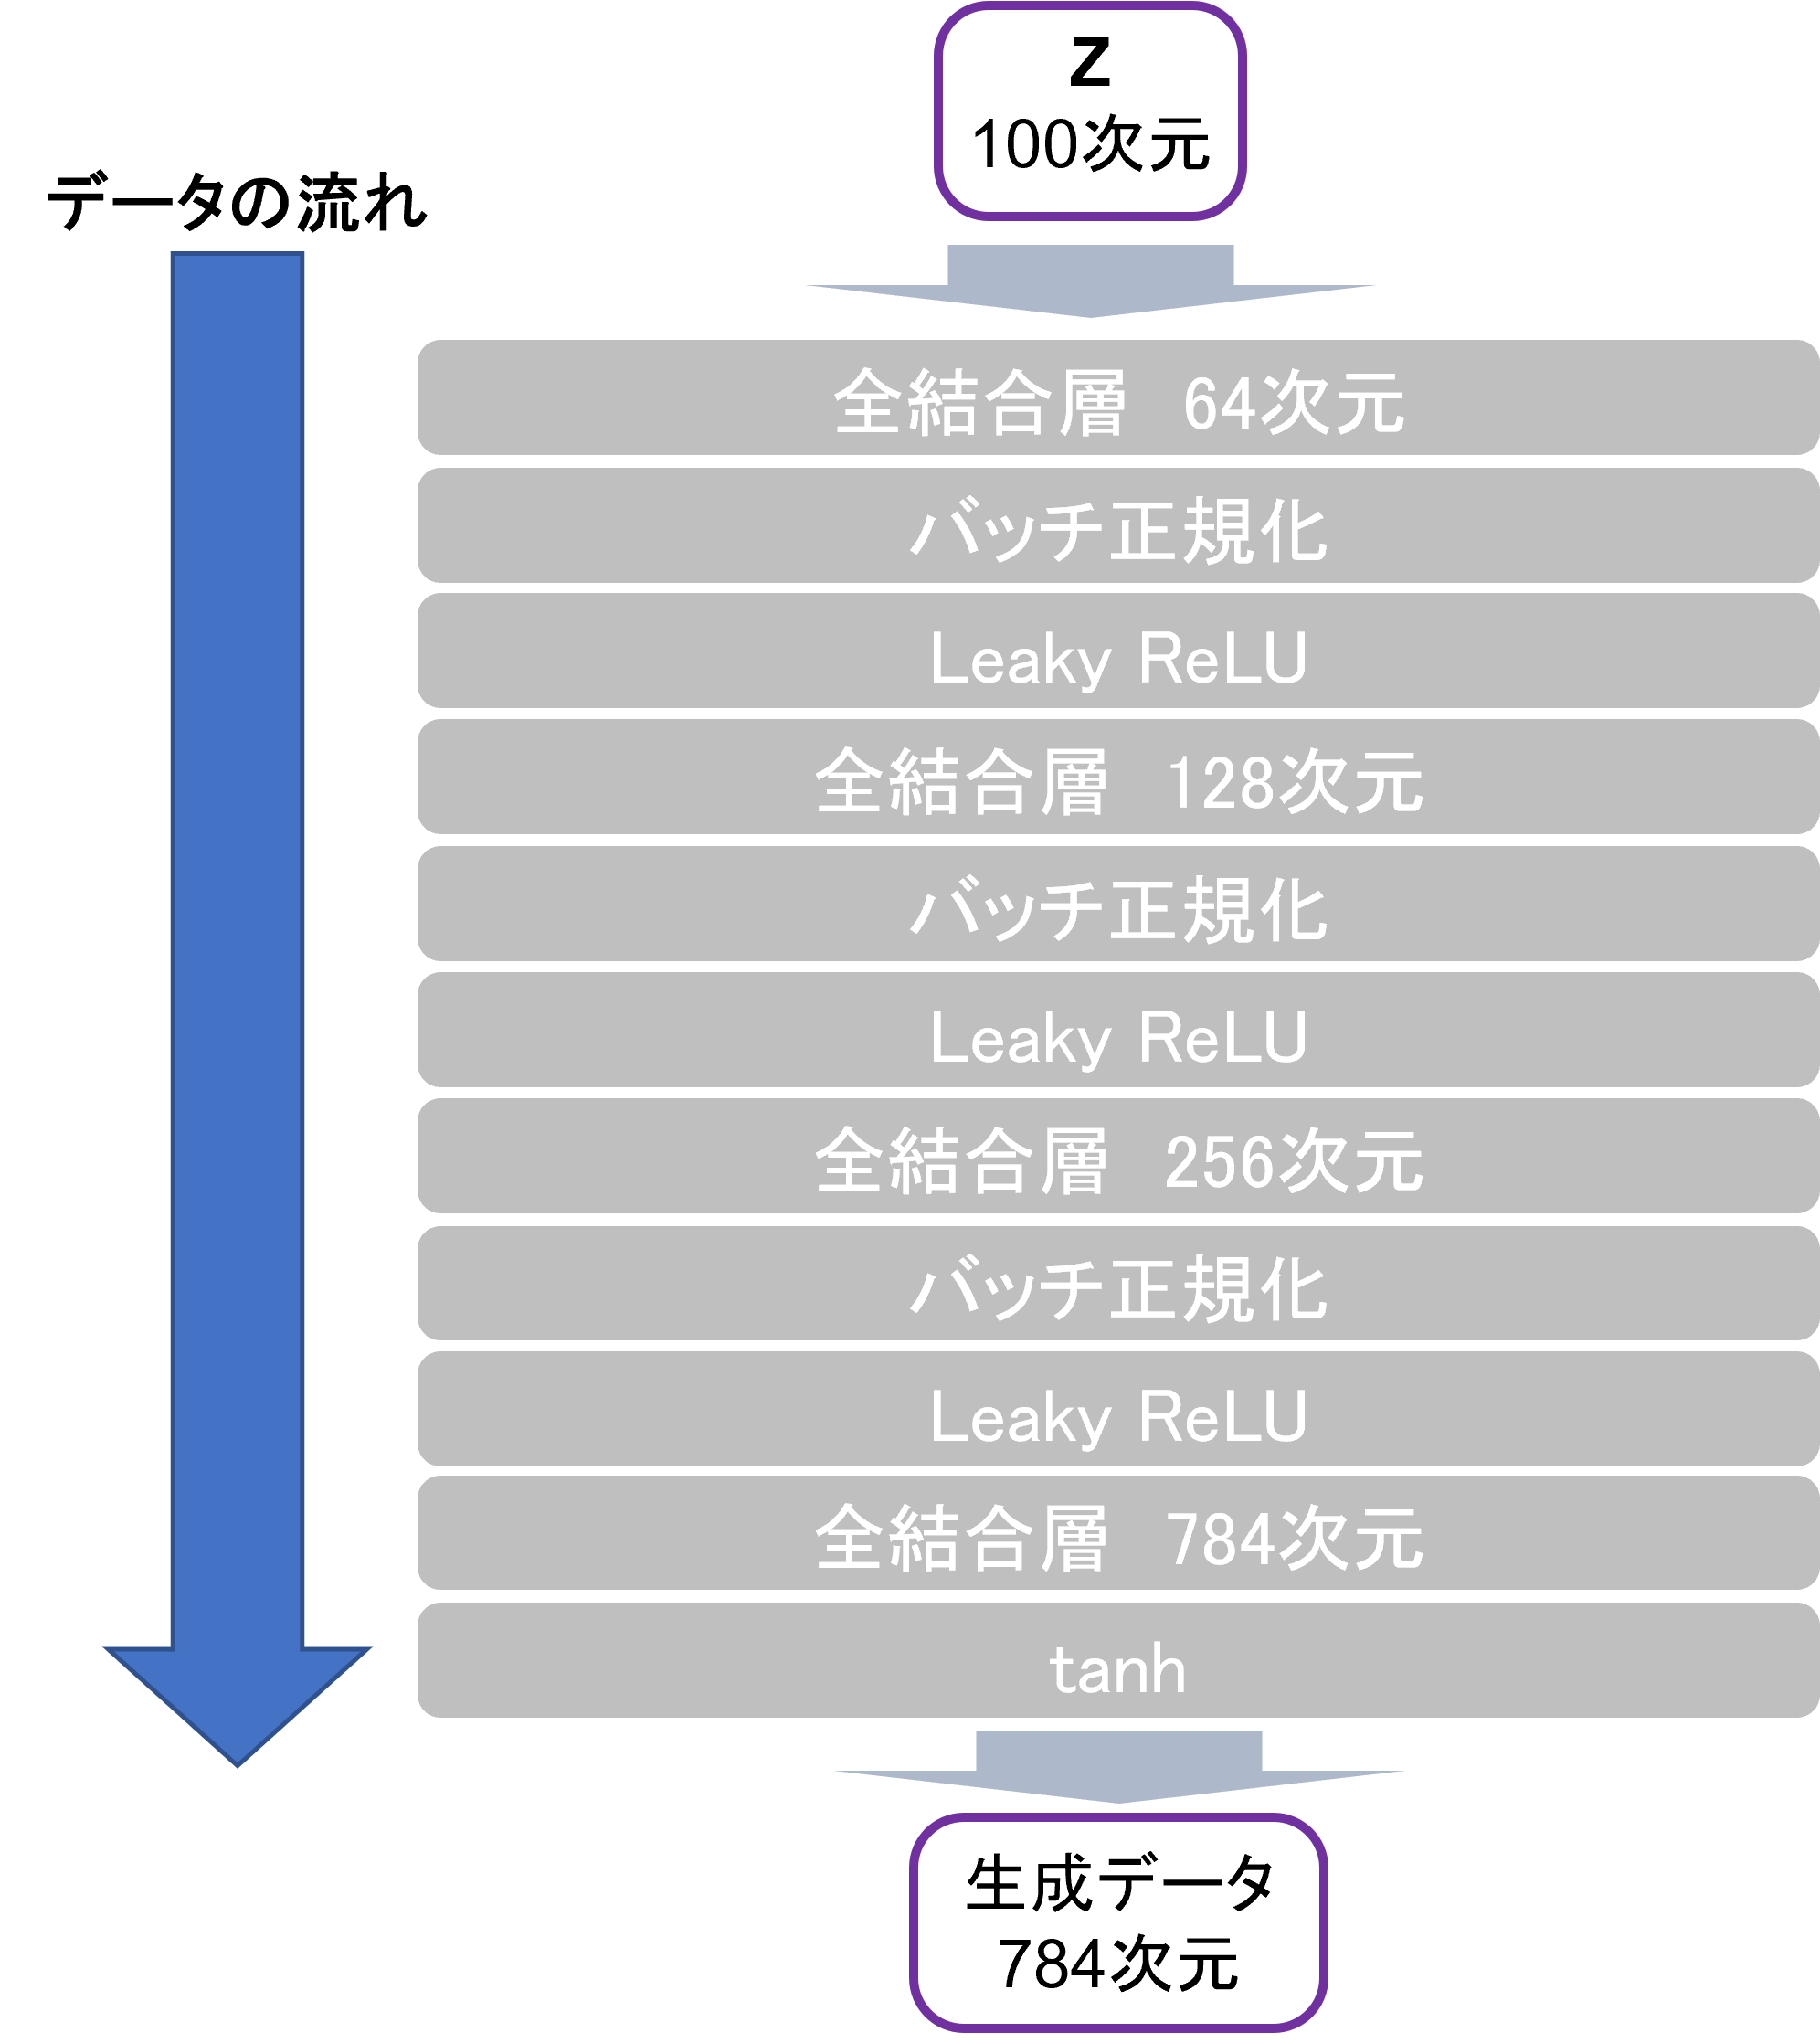


#### Generatorクラス
* <font color="Red">問1. Generatorクラスを完成させましょう。</font><br>
  * <font color="Red">問1-1. Generatorにおける最初の全結合層を定義しましょう。出力は```feature_size```とします。</font><br>
  * <font color="Red">問1-2. Generatorにおける最初のバッチ正規化層を定義しましょう。</font><br>
  * <font color="Red">問1-3. Generatorにおける最初のバッチ正規化層後の活性化関数Leaky ReLUを定義しましょう。引数の```negative_slope```は```0.2```とします。</font><br>

```
【ヒント】Generatorクラスの引数
  z_size: 一様乱数からサンプリングされるノイズzの次元数。
  feature_size: 最初の全結合層の次元数。
  ngpu: 使用できるGPUの数。今回は解答に使用しません。
```

In [ ]:
class Generator(nn.Module):
    def __init__(self, z_size, feature_size, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.net = nn.Sequential(
            ### 問1-1 ###
            ### 問1-2 ###
            ### 問1-3 ###
            
            nn.Linear(feature_size, feature_size * 2),
            nn.BatchNorm1d(feature_size * 2),
            nn.LeakyReLU(0.2),
            
            nn.Linear(feature_size * 2, feature_size * 4),
            nn.BatchNorm1d(feature_size * 4),
            nn.LeakyReLU(0.2),
            
            nn.Linear(feature_size * 4, 28 * 28),
            nn.Tanh()
        )
    
    def forward(self, input):
        x = input.view(-1, 100)
        x = self.net(x)
        x = x.view(-1, 28, 28)
        return x

### 識別器


識別器を実装します。

今回は次の構造を持つ識別器を構築しましょう。

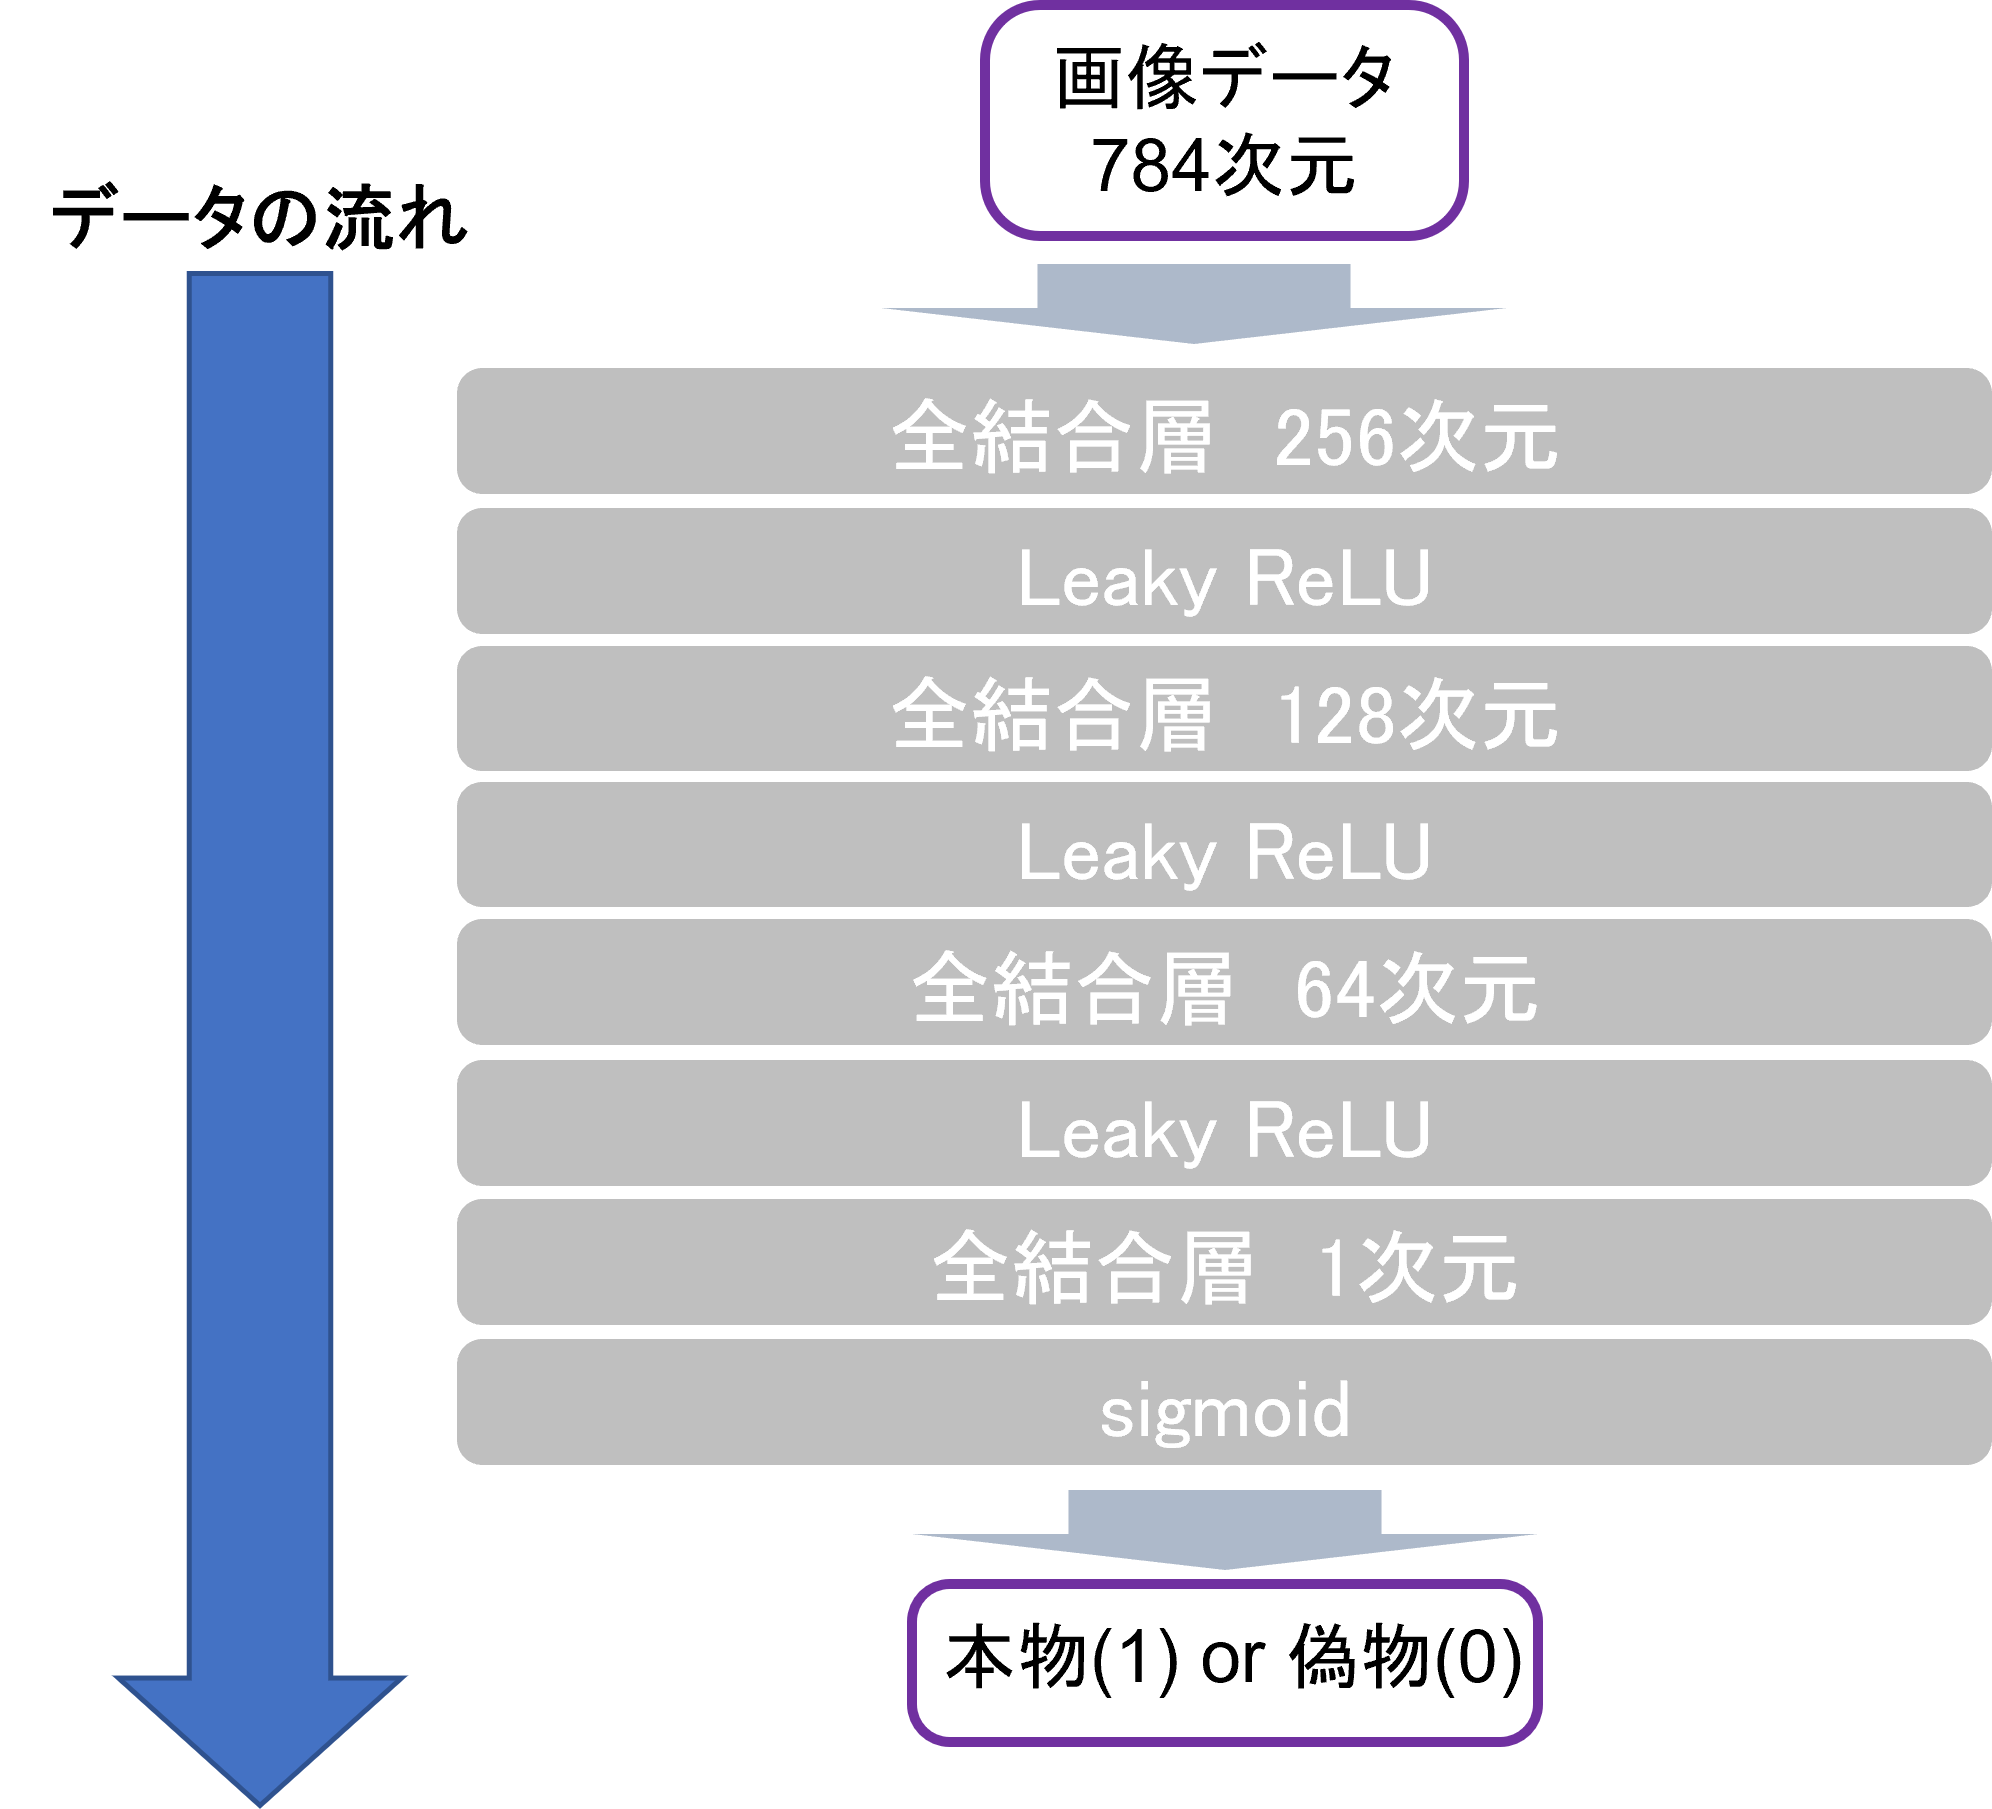

#### Discriminatorクラス
* <font color="Red">問2. Discriminatorクラスを完成させる</font><br>
  * <font color="Red">問2-1. Discriminatorにおける最初の全結合層を定義しましょう。出力は```feature_size*4```とします。</font><br>
  * <font color="Red">問2-2. Discriminatorにおける最初の全結合層後の活性化関数Leaky ReLUを定義しましょう。引数の```negative_slope```は```0.2```とします。</font><br>


In [ ]:
class Discriminator(nn.Module):
    def __init__(self, feature_size, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.net = nn.Sequential(
            ### 問2-1 ###
            ### 問2-2 ###
            
            nn.Linear(feature_size * 4, feature_size * 2),
            nn.LeakyReLU(0.2),
            
            nn.Linear(feature_size * 2, feature_size),
            nn.LeakyReLU(0.2),
            
            nn.Linear(feature_size, 1),
            nn.Sigmoid()
        )
    def forward(self, input):
        x = input.view(-1, 28*28)
        x = self.net(x)
        x = x.view(-1)
        return x

### 学習

In [ ]:
ngpu = 1 #使用可能なGPUの数
feature_sizeG = 64
feature_sizeD = 64
z_size = 100

modelG = Generator(z_size, feature_sizeG, ngpu).to(device)
modelD = Discriminator(feature_sizeD, ngpu).to(device)

if (device.type == 'cuda') and (ngpu > 1):
    modelG = nn.DataParallel(modelG, list(range(ngpu)))
if (device.type == 'cuda') and (ngpu > 1):
    modelD = nn.DataParallel(modelD, list(range(ngpu)))

lr = 0.0002
beta1 = 0.5
beta2 = 0.999

criterion = nn.BCELoss()

real_label = 1.
fake_label = 0.

optimizerG = optim.Adam(modelG.parameters(), lr=lr, betas=(beta1, beta2))
optimizerD = optim.Adam(modelD.parameters(), lr=lr, betas=(beta1, beta2))

n_epochs = 15
torch.manual_seed(0)
# ジェネレータの進行を視覚化するために使用する潜在ベクトルを作成します
fixed_noise = torch.randn(batch_size, z_size, 1, 1, device=device)

img_list = []
G_losses = []
D_losses = []
iters = 0

for epoch in range(n_epochs):
    for i, X_train in enumerate(dataloader_train, 0):
        modelD.zero_grad()
        X_train = X_train[0].to(device)
        batch_size_epoch = len(X_train)
        label = torch.full((batch_size_epoch,), real_label, dtype=torch.float, device=device)
        output = modelD(X_train)
        lossD_real = criterion(output, label)
        lossD_real.backward()
        D_x = output.mean().item() # これが1に近ければよい(=accuracy)
        
        #偽画像での学習
        noise = torch.randn(batch_size_epoch, z_size, 1, 1, device=device)
        fake = modelG(noise)
        label.fill_(fake_label)
        output = modelD(fake.detach())
        lossD_fake = criterion(output, label)
        lossD_fake.backward()
        D_G_z1 = output.mean().item()
        lossD = lossD_real + lossD_fake
        optimizerD.step()
        
        # 生成器ネットワークの更新 -> log(1-D(G(z)))の最小化
        modelG.zero_grad()
        label.fill_(real_label)
        output = modelD(fake)
        lossG = criterion(output, label)
        lossG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()
        
        if i % 100 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, n_epochs, i, len(dataloader_train),
                     lossD.item(), lossG.item(), D_x, D_G_z1, D_G_z2))
        
        G_losses.append(lossG.item())
        D_losses.append(lossD.item())
        
        # fixed_noiseによる G の出力を保存し、生成器の精度を確認します
        if (iters % 500 == 0) or ((epoch == n_epochs-1) and (i == len(dataloader_train)-1)):
            with torch.no_grad():
                fake = modelG(fixed_noise).detach().cpu().reshape((-1, 1, 28, 28))
            img_list.append(torchvision.utils.make_grid(fake, padding=2, normalize=True))

        iters += 1

In [ ]:
# 損失推移
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

### 学習結果の可視化（MNISTの生成）

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
anim = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(anim.to_jshtml())

In [ ]:
# データローダから実際の画像のバッチを取得します
real_batch = next(iter(dataloader_train))

# 実際の画像をプロットします
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(real_batch[0].to(device)[:batch_size], padding=2, normalize=True).cpu(),(1,2,0)))

# 最後のエポックからの偽の画像をプロットします
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

## DCGANを用いた画像生成（PyTorch） 

DCGANの学習方針はGANと同様です。

GANとの違いはGeneratorとDiscriminatorがNNではなく畳み込みニューラルネットワーク(CNN)で構築されている点です。

ネットワークを深くした場合であっても安定して学習を進めることが出来るため、生成できる画像の幅が広がります。

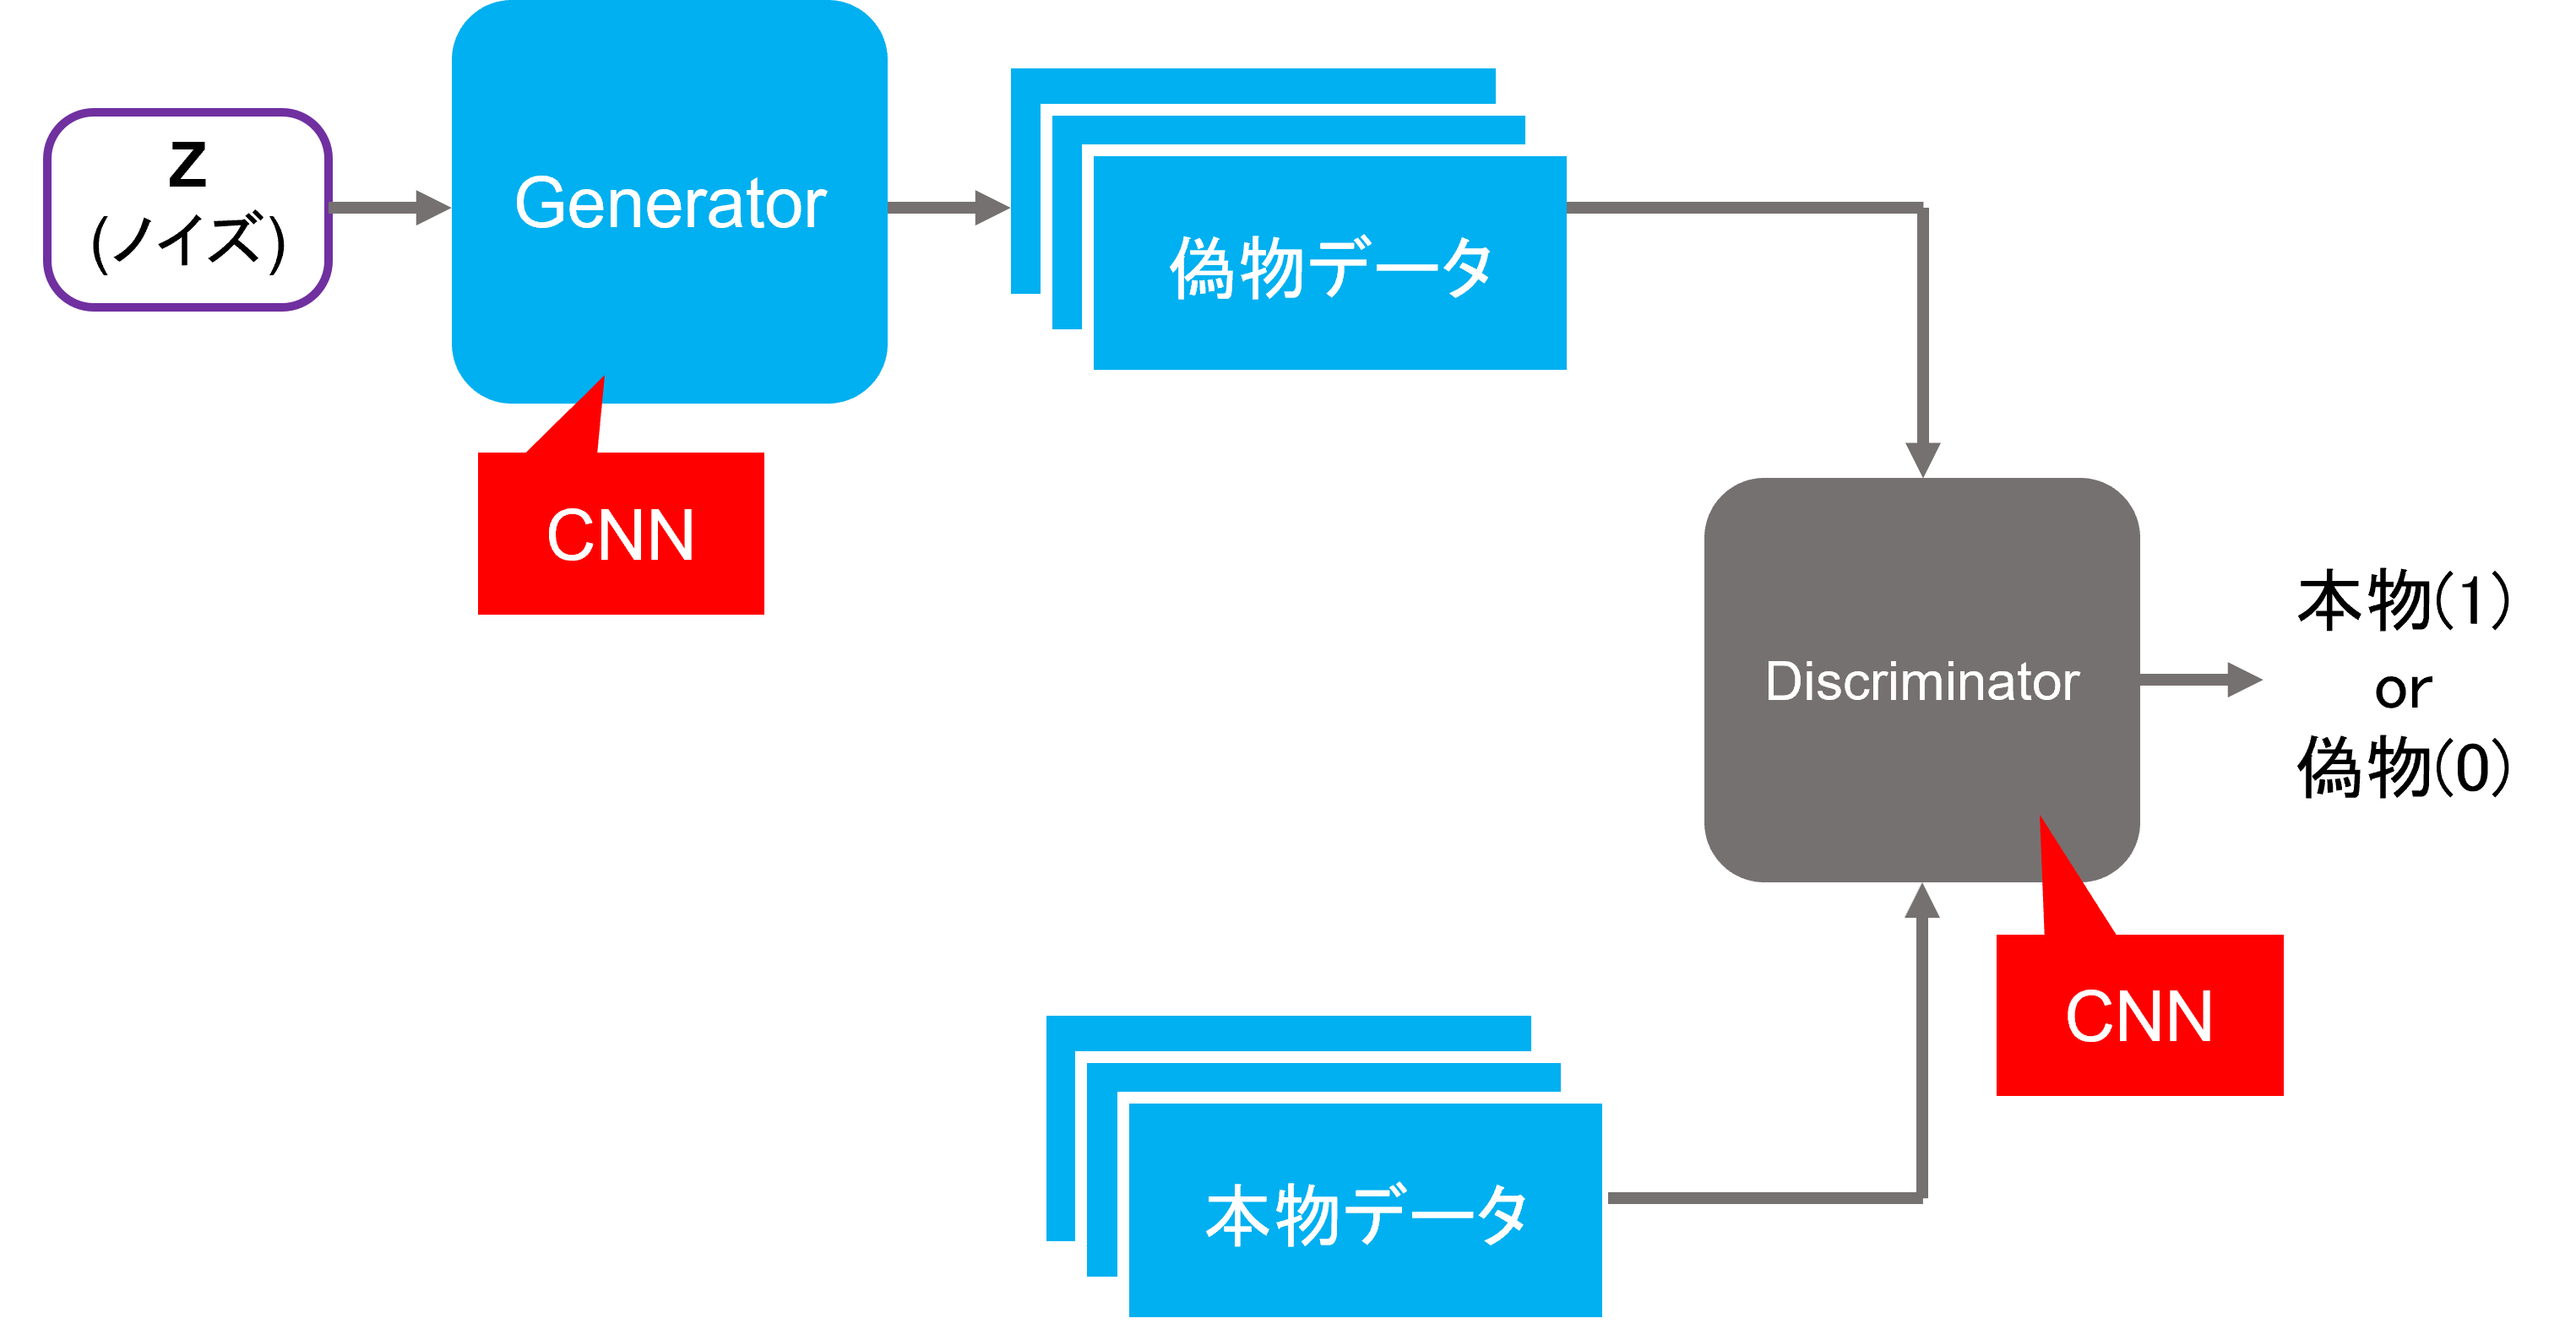

### データセットの用意

In [ ]:
batch_size = 64
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset_train = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)


# plane, carのデータのみ抽出する
X = []
y = []
for data in tqdm(dataset_train):
    if data[1] == 0 or data[1] == 1:
        X.append(data[0].detach().numpy().tolist())
        y.append(data[1])
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.int64)

dataset_train = torch.utils.data.TensorDataset(X, y)
dataloader_train = torch.utils.data.DataLoader(
    dataset_train,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

classies = ['plane', 'car']
print("データローダの作成が終わりました")

In [ ]:
# データの確認
batch = next(iter(dataloader_train))
print(batch[0].shape)
plt.figure(figsize=(8,8))
plt.axis('off')
plt.title('training images')
plt.imshow(np.transpose(torchvision.utils.make_grid(batch[0].to(device)[:batch_size], padding=2, normalize=True).cpu(),(1,2,0)))

### 生成器
生成器を実装します。

今回は次の構造を持つ生成器を構築しましょう。


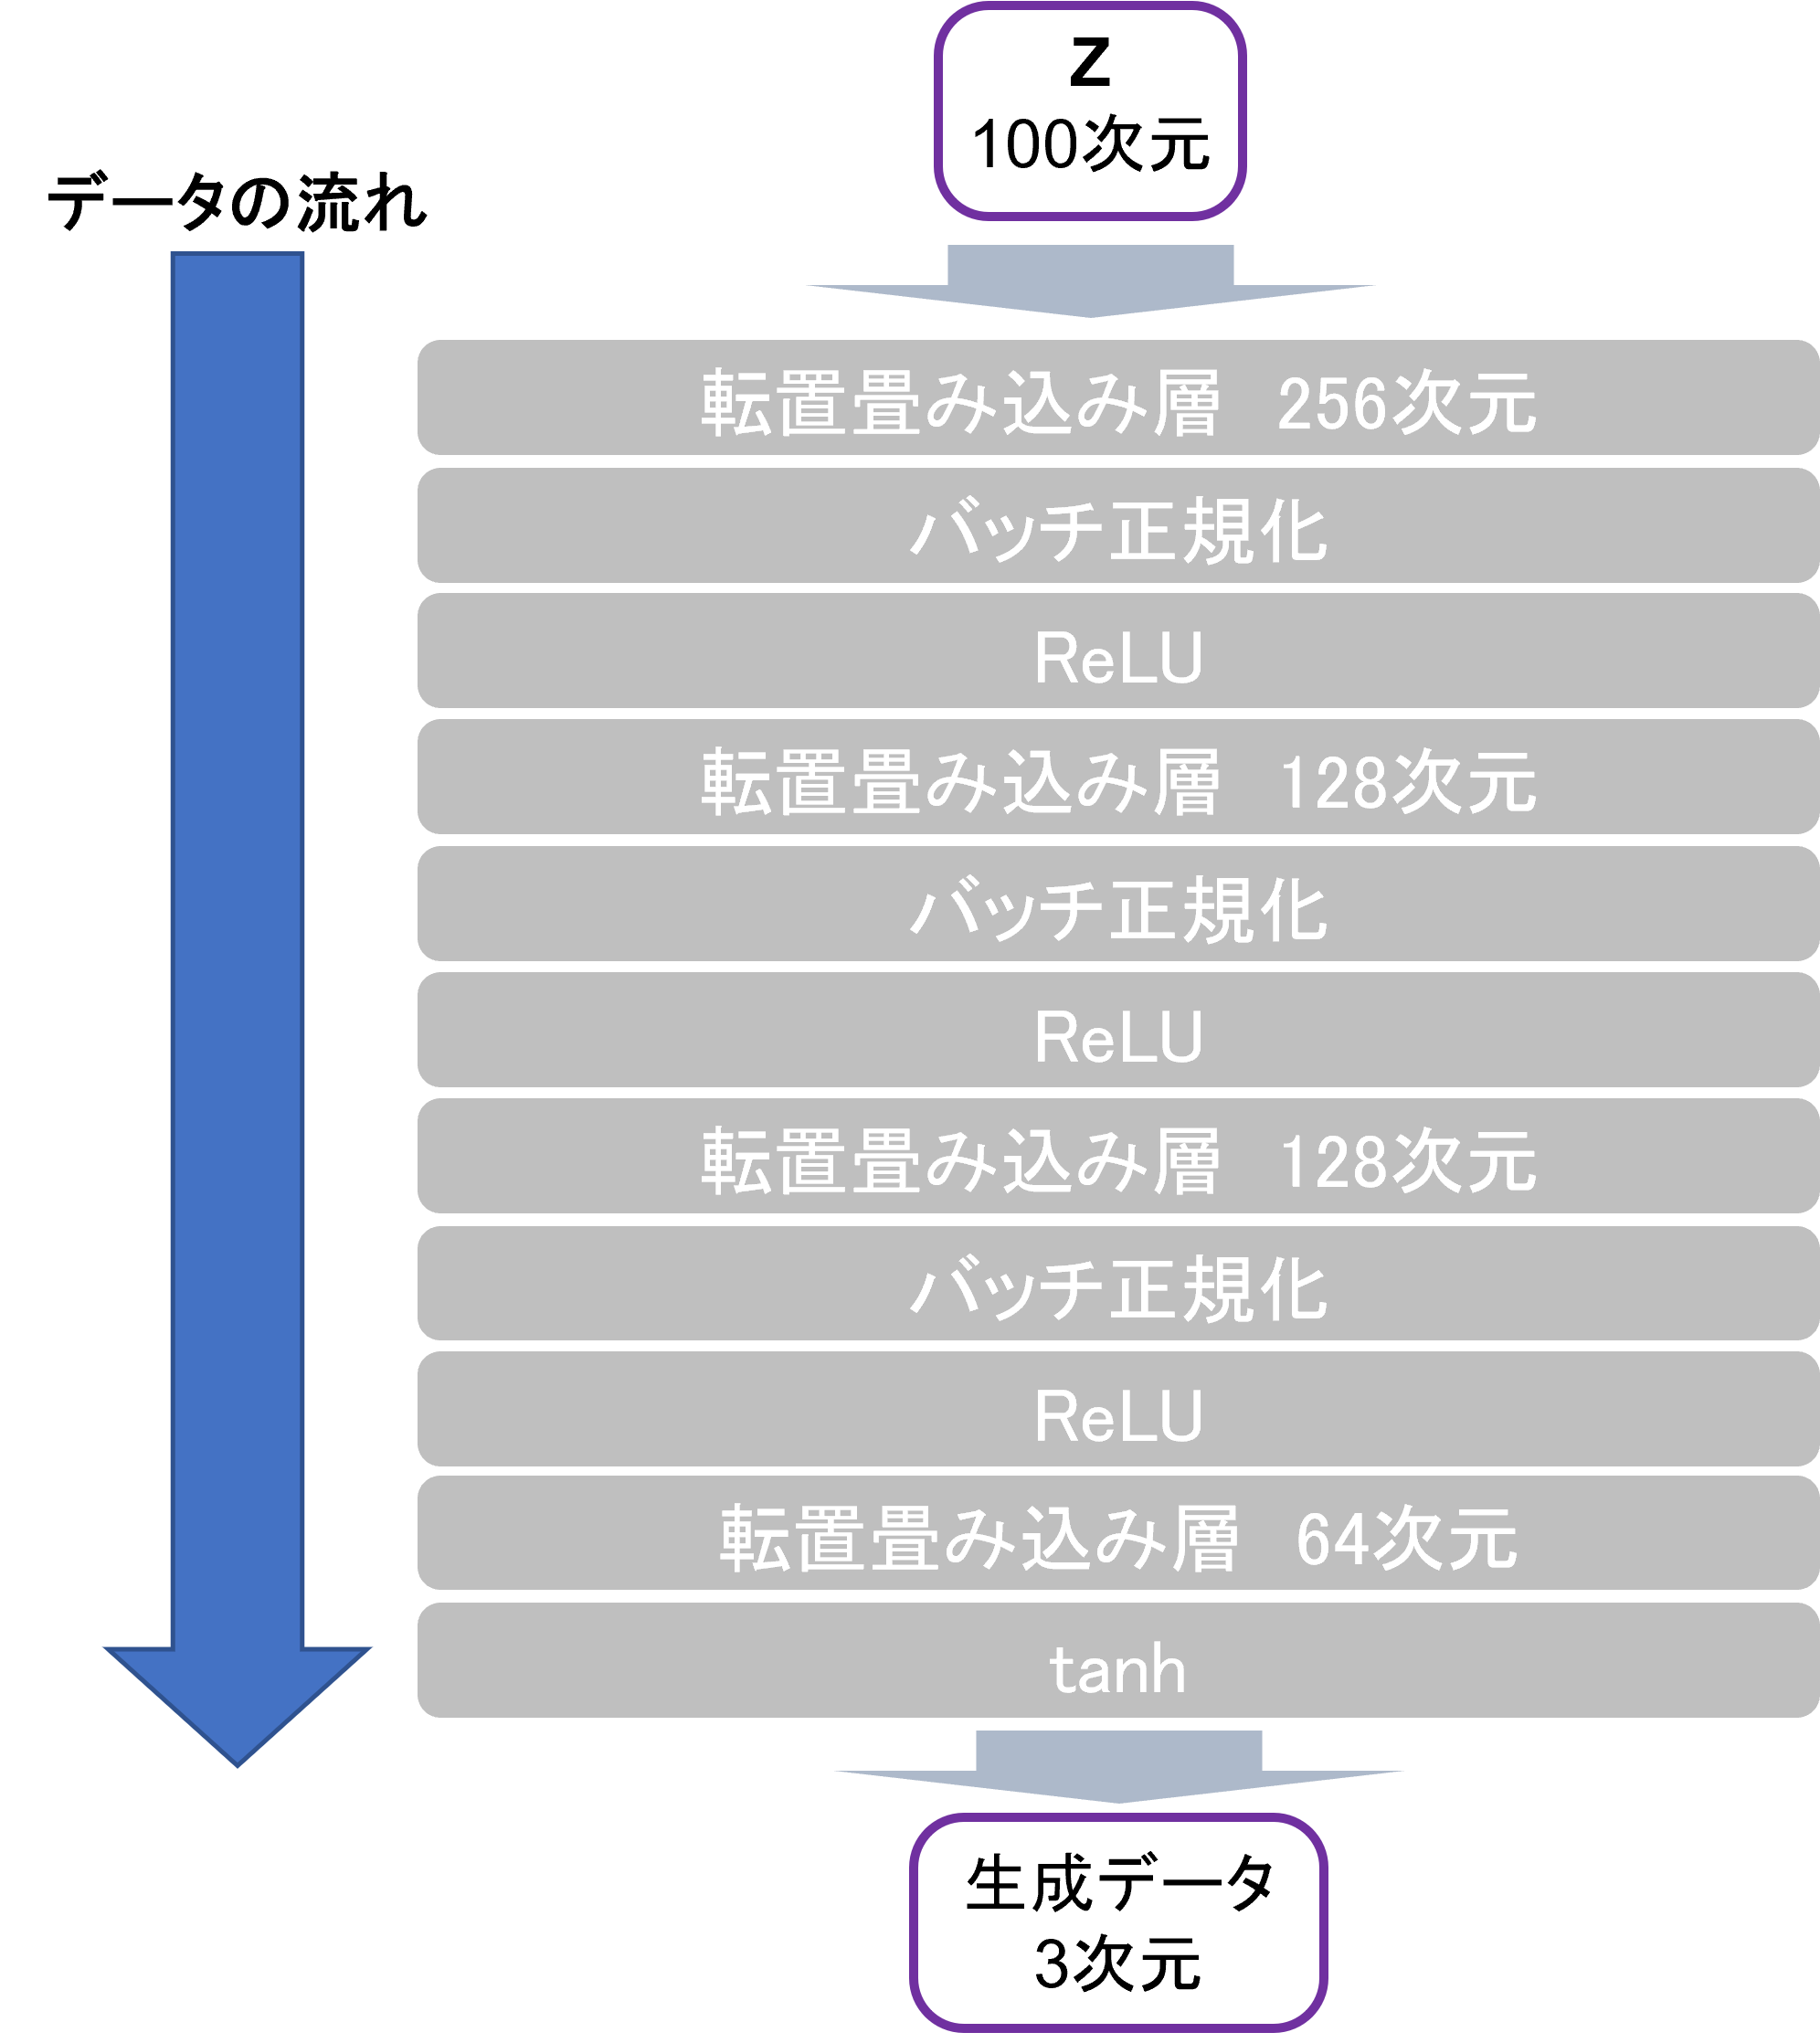

In [ ]:
# 生成器の定義
class Generator(nn.Module):
    def __init__(self, channel_size, z_size, feature_size, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.net = nn.Sequential(
            nn.ConvTranspose2d(z_size, feature_size * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(feature_size * 4),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(feature_size * 4, feature_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size * 2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d( feature_size * 2, feature_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size * 2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d( feature_size * 2, channel_size, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.net(input)

### 識別器
識別器を実装します。

今回は次の構造を持つ識別器を構築しましょう。

ただし、活性化関数`Leaky ReLU`の`negative_slope`は`0.2`とします。

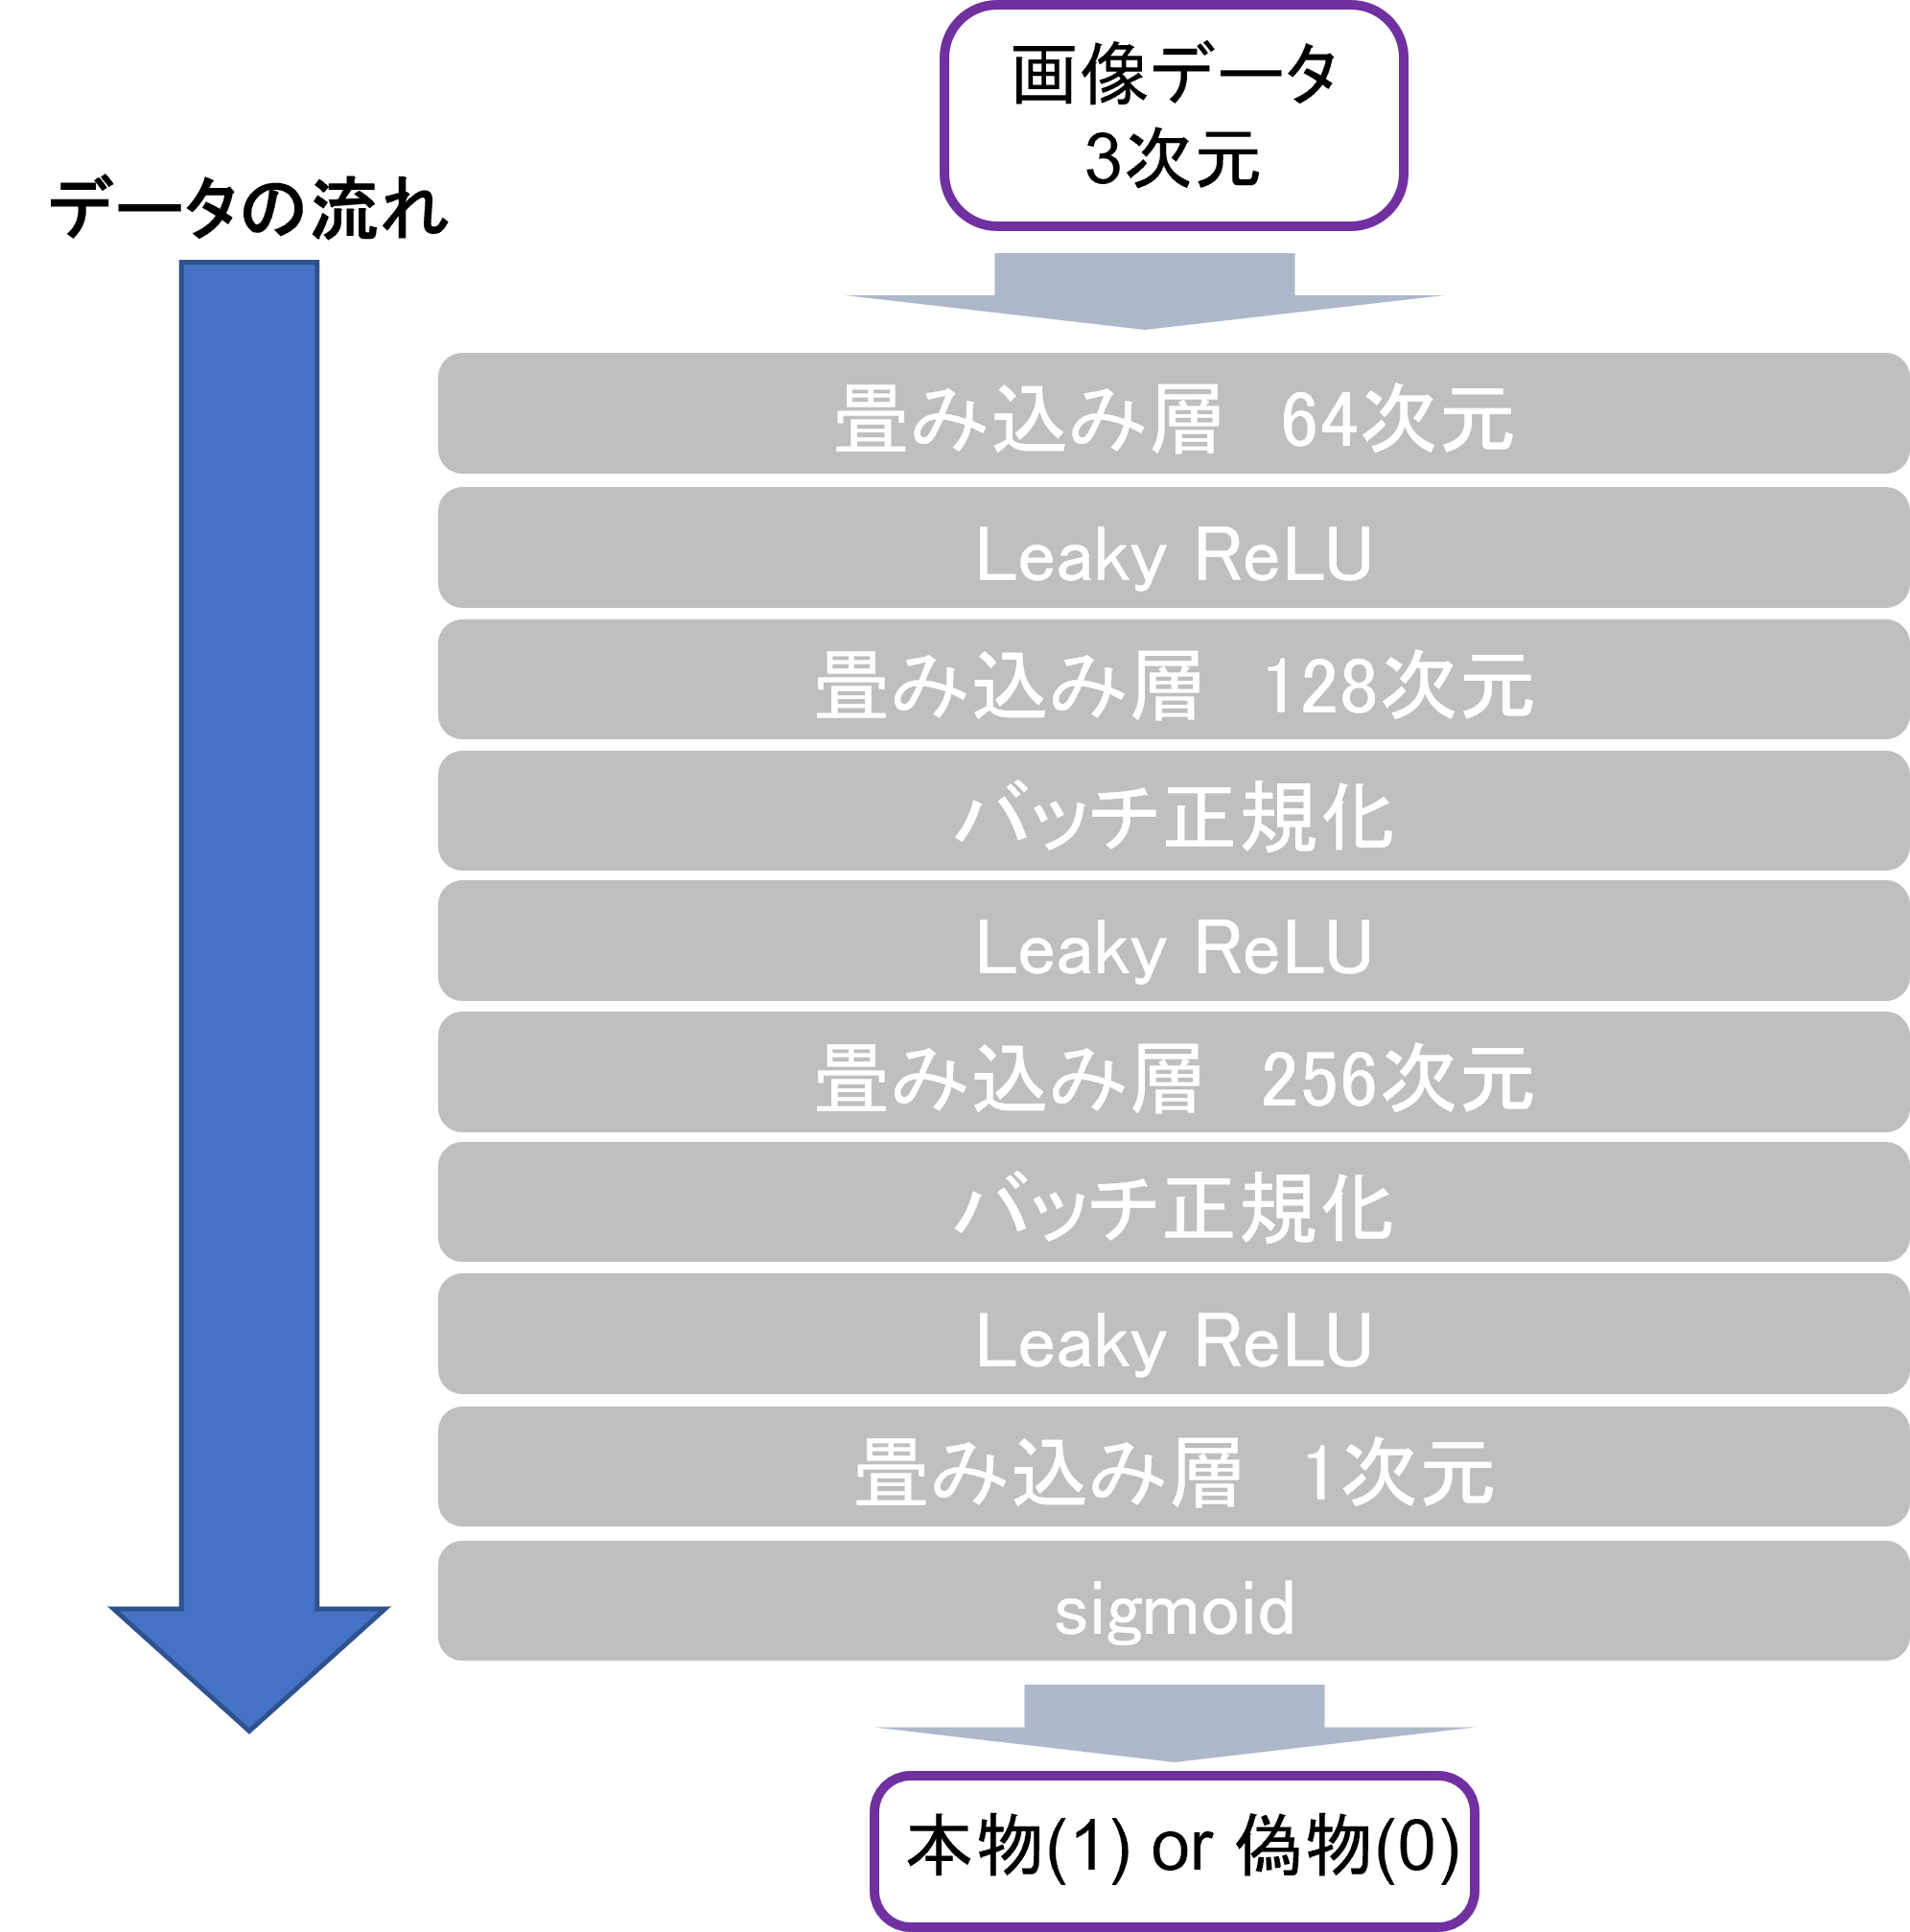

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, channel_size, feature_size, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.net = nn.Sequential(
            nn.Conv2d(channel_size, feature_size, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_size, feature_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_size * 2, feature_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_size * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
    def forward(self, input):
        return self.net(input).view(-1, 1).squeeze(1)

### 重み初期化

DCGANの論文ではモデルの重みを平均0、標準偏差0.02の正規分布からランダムに初期化することが明示されています。

そのため今回は、畳み込み層の重みを平均0、標準偏差0.02の正規分布で初期化します。

また、バッチ正規化層の重みを平均1、標準偏差0.02の正規分布で初期化します。



#### 重みの初期化
* <font color="Red">問3. 畳み込み層とバッチ正規化層の重みを初期化する関数を完成させましょう。</font><br>
  * <font color="Red">問3-1. ```nn.init.normal_```関数を使って平均0, 標準偏差0.02の正規分布からランダムに初期化する処理を記述しよう。</font><br>
  * <font color="Red">問3-2. ```nn.init.normal_```関数を使って平均1, 標準偏差0.02の正規分布からランダムに初期化する処理を記述しよう。</font><br>

```
【ヒント➀】torch.nn.init.normal_(tensor, mean=0.0, std=1.0)の引数
  tensor: 重みを初期化するTensor
  正規分布N(mean, std^2)からサンプリングされた値でtensorを初期化します
```
```
【ヒント➁】モデルの重みのTensorは```m.weight.data```で参照できます。
```

In [ ]:
# 重みの初期化を行う関数
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        ### 問3-1 ###
    elif classname.find('BatchNorm') != -1:
        ### 問3-2 ###
        nn.init.constant_(m.bias.data, 0)

### 学習

GeneratorおよびDiscriminatorの損失計算はバイナリクロスエントロピー誤差を使用します。

$$
\rm{loss} = -t\log{y}-(1-t)\log{(1-y)}
$$


Pytorchではtorch.nnライブラリのtorch.nn.BCELoss()を使用します。

torch.nn.BCELoss()では第一引数にモデルの出力、第二引数に教師出力を与えます。


#### 損失計算
* <font color="Red">問4-1, 4-2. ```lossD_real```と```lossD_fake```に識別器の損失計算を行う関数を記述しよう</font><br>
* <font color="Red">問5. ```lossG```に生成器の損失計算を行う関数を記述しよう</font><br>

【補足】損失関数は```criterion```で定義されている

In [ ]:
ngpu = 1 #使用可能なGPUの数
channel_size = 3
feature_sizeG = 64
feature_sizeD = 64
z_size = 100

modelG = Generator(channel_size, z_size, feature_sizeG, ngpu).to(device)
modelD = Discriminator(channel_size, feature_sizeD, ngpu).to(device)

# weights_init関数を適用して重みを初期化する
modelG.apply(weights_init)
modelD.apply(weights_init)

if (device.type == 'cuda') and (ngpu > 1):
    modelG = nn.DataParallel(modelG, list(range(ngpu)))
if (device.type == 'cuda') and (ngpu > 1):
    modelD = nn.DataParallel(modelD, list(range(ngpu)))

lr = 0.0002
beta1 = 0.5
beta2 = 0.999
real_label = 1.
fake_label = 0.
optimizerG = optim.Adam(modelG.parameters(), lr=lr, betas=(beta1, beta2))
optimizerD = optim.Adam(modelD.parameters(), lr=lr, betas=(beta1, beta2))
criterion = nn.BCELoss()
n_epochs = 15
torch.manual_seed(0)
# ジェネレータの進行を視覚化するために使用する潜在ベクトルを作成します
fixed_noise = torch.randn(batch_size, z_size, 1, 1, device=device)

img_list = []
G_losses = []
D_losses = []
iters = 0
for epoch in range(n_epochs):
    for i, X_train in enumerate(dataloader_train, 0):
        modelD.zero_grad()
        X_train = X_train[0].to(device)
        batch_size_epoch = len(X_train)
        label = torch.full((batch_size_epoch,), real_label, dtype=torch.float, device=device)
        output = modelD(X_train)
        ### 問4-1 ###
        lossD_real.backward()
        D_x = output.mean().item() # これが1に近ければよい(=accuracy)
        
        #偽画像での学習
        noise = torch.randn(batch_size_epoch, z_size, 1, 1, device=device)
        fake = modelG(noise)
        label.fill_(fake_label)
        output = modelD(fake.detach())
        ### 問4-2 ###
        lossD_fake.backward()
        D_G_z1 = output.mean().item()
        lossD = lossD_real + lossD_fake
        optimizerD.step()
        
        # 生成器ネットワークの更新 -> log(1-D(G(z)))の最小化
        modelG.zero_grad()
        label.fill_(real_label)
        output = modelD(fake)
        ### 問5 ###
        lossG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()
        
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, n_epochs, i, len(dataloader_train),
                     lossD.item(), lossG.item(), D_x, D_G_z1, D_G_z2))
        
        G_losses.append(lossG.item())
        D_losses.append(lossD.item())
        
        # fixed_noiseによる G の出力を保存し、生成器の精度を確認します
        if (iters % 500 == 0) or ((epoch == n_epochs-1) and (i == len(dataloader_train)-1)):
            with torch.no_grad():
                fake = modelG(fixed_noise).detach().cpu()
            print(fake.shape)
            img_list.append(torchvision.utils.make_grid(fake, padding=2, normalize=True))

        iters += 1

In [ ]:
# 損失推移
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
anim = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(anim.to_jshtml())

In [ ]:
# データローダから実際の画像のバッチを取得します
real_batch = next(iter(dataloader_train))

# 実際の画像をプロットします
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(real_batch[0].to(device)[:batch_size], padding=2, normalize=True).cpu(),(1,2,0)))

# 最後のエポックからの偽の画像をプロットします
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()